In [1]:
## Import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pyOptimalEstimation as pyOE
import os
import sys
import re
import scipy.stats as stats
import seaborn as sns

## append paths
sys.path.append('C:/Users/Ida Olsen/Documents/Speciale_2022/scripts')
parrent_dir = "C:\\Users\\Ida Olsen\\Documents\\Speciale_2022"
sys.path.append(parrent_dir + '\\smrt')
sys.path.append(parrent_dir + '\\Ida_passive_SMRT\\Ida_passive_SMRT\\Code')

## Import SMRT packages
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_ice_column, make_interface, make_snowpack, sensor_list
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt import SMRTError
from IPython.display import clear_output

## self made modules
from Snowpit_class import Snowpit_info
from roughness import roughness
from Make_plots import plot_freq
from forward_functions_AMSR2 import forward_OIB_AMSR2
from prepare_inputs_OE_AMSR2 import prepare_inputs_FYI_AMSR2 as piO
from prepare_inputs_OE import OIB_data

In [2]:
def corrMat(self, data, specifier=''):
    ## Make correlation matrix - input covariance matrix
    corrMat = np.zeros(data.shape)
    sigmas = np.diag(data)**(1/2)
    rows = range(data.shape[0])
    cols = range(data.shape[1])
    for row in rows:
        sigma1 = sigmas[row]
        for col in cols:
            sigma2 = sigmas[col]

            corrMat[row][col] = np.array(data)[row][col]/(sigma1*sigma2)

    fig, ax = plt.subplots(figsize=(9, 6))
    im = ax.imshow(corrMat, cmap="inferno")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(self.S_a.keys())), labels=self.S_a.keys())
    ax.set_yticks(np.arange(len(self.S_a.keys())), labels=self.S_a.keys())

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    for i in range(len(self.S_a.keys())):
        for j in range(len(self.S_a.keys())):
            if np.round(corrMat[i, j],2) > 0.5:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                       ha="center", va="center", color="k")
            else:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                               ha="center", va="center", color="w")

    ax.set_title(r'Output correlation matrix')
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


    fig.tight_layout()
    plt.savefig(savepath + str(specifier) + '_CorrOut.png' )
    plt.show()
    
def covMat(self, data, title, specifier=''):
    for var in self.x_vars:
        print(var)
        data[var][var] = data[var][var]**(1/2)
    ## get std
    try:
       data['lex']['lex'] = data['lex']['lex']*1e1
    except:
        pass
    try:
        data['sal']['sal'] = data['sal']['sal']*1e1
    except:
        pass
    try:
        data['rho']['rho'] = data['rho']['rho']*1e-2
    except:
        pass
    try:
        data['Tsur']['Tsur'] = data['Tsur']['Tsur']/1e2
    except:
        pass
    try:
        data['slope']['slope'] = data['slope']['slope']/1e2
    except:
        pass
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(
        data*1e2,
        annot=True, 
        fmt='.2f', 
        ax=ax, 
        linewidths=.05, 
        cbar_kws={'label':'Modified Covariance [cm,mm,kg/m3,PSU,K,cm,'']'}
        # cbar_kws={'label':'Modified Covariance [log10(cm),log10(mm),log10(PSU),cm]'}
    )
    ax.set_title(title)
    if 'out' in title:
        plt.savefig(savepath  + specifier + '_CovOut.png' )
    else:
        plt.savefig(savepath  + specifier +'_CovIn.png' )
    plt.show()
def covMat_orig(self, data, title):
    for i in range(len(self.x_vars)):
        data[i][i] = data[i][i]**(1/2)
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(
        data,
        annot=True, 
        fmt='.4f', 
        ax=ax, 
        linewidths=.05, 
        cbar_kws={'label':'Modified Covariance [cm,mm,kg/m3,PSU,K,cm,'']'}
        # cbar_kws={'label':'Modified Covariance [log10(cm),log10(mm),log10(PSU),cm]'}
    )
    ax.set_title(title)
    if 'out' in title:
        plt.savefig(savepath  + '_CovOut.png' )
    else:
        plt.savefig(savepath  +'_CovIn.png' )
    plt.show()
def makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB):
    nl_snow = 3
    forwardKwArgs = {"self": FYI_data, "variables": x_vars, "nl_snow": nl_snow, "n": 0, 
                     "pol":polarization, "logarithmic":True,"avg":True, "sim":False}
    oe = pyOE.optimalEstimation(
    x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2
    ,forwardKwArgs=forwardKwArgs
    ,x_lowerLimit=x_lowerLimit
    ,x_upperLimit=x_upperLimit
    )
    return oe
def calc_ang(var1, var2):
    
    text_file = open(savepath + "angles_jacobian.txt", "a")
    
    J = oe.getJacobian(oe.x_op, oe.y_op)[0]
    print('--------------------------------------------------')
    text_file.write('--------------------------------------------------\n')
    
    denominator = np.linalg.norm(J['perturbed '+var1][:5])*np.linalg.norm(J['perturbed '+var2][:5])
    nominator = np.dot(J['perturbed '+var1][:5], J['perturbed '+var2][:5])
    print('Angle between '+var1+' and '+var2+' vector V:', np.rad2deg(np.arccos(nominator/denominator)))
    text_file.write('Angle between '+var1+' and '+var2+' vector V:' + str(np.rad2deg(np.arccos(nominator/denominator))) + '\n')

    
    denominator = np.linalg.norm(J['perturbed '+var1][5:])*np.linalg.norm(J['perturbed '+var2][5:])
    nominator = np.dot(J['perturbed '+var1][5:], J['perturbed '+var2][5:])
    print('Angle between '+var1+' and '+var2+ ' vector H:', np.rad2deg(np.arccos(nominator/denominator)))
    text_file.write('Angle between '+var1+' and '+var2+' vector H:' + str(np.rad2deg(np.arccos(nominator/denominator))) + '\n')
def covOutMat(oe1, oe2, name):
    data=oe1/oe2
    f, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(
        data,
        cmap="rocket_r",
        annot=True, 
        fmt='.2f', 
        ax=ax, 
        linewidths=.08,
        cbar=False,
        cbar_kws={"shrink": 0.5, 'label':'Ratio of covariance compared to input'}
    )
    ax.set_title('$\mathbf{S}_{op}$/$\mathbf{S}_{a}$ posterior to prior state covariance matrix')
    plt.savefig(savepath + 'CovRatioOuttoIn.png' )
    plt.show()

In [3]:
FYI_data = OIB_data('FYI', new=False)
logarithmic = True
if logarithmic ==True:
    FYI_data.sd = np.log10(np.sum(FYI_data.sd, axis=1))
    FYI_data.sd_lex = np.log10(np.mean(FYI_data.sd_lex, axis=1))
else:
    FYI_data.sd = np.sum(FYI_data.sd, axis=1)
    FYI_data.sd_lex = np.mean(FYI_data.sd_lex, axis=1)
    # FYI_data.sd_sal = np.log10(np.sum(FYI_data.sd_sal, axis=1))
# FYI_sim_TB_mean = np.concatenate(([[TbV, TbH] for TbV, TbH in zip(FYI_data.TbV_sim, FYI_data.TbH_sim)]))
print(np.mean(FYI_data.TbV_sim, axis=0))
# print(FYI_data.TbH_sim)
FYI_OIB_AMSR = np.concatenate([np.mean(FYI_data.TbV_AMSR_all, axis=0), np.mean(FYI_data.TbH_AMSR_all, axis=0)])
FYI_OIB_AMSR_std = np.concatenate([np.std(FYI_data.TbV_AMSR_all, axis=0), np.std(FYI_data.TbH_AMSR_all, axis=0)])

[256.49983266 256.90524812 257.36732577 257.48747597 255.95167513]


In [4]:
# Saving location
savepath = 'C:/Users/Ida Olsen/Documents/Speciale_2022/Results/Real_data/Only V/know_SIT/'

# Numebr of layers
nl_snow = 3
# Polarization (V or both)
polarization = 'both'
# sensitivity of TBs (std)
V_sens = 0.5 # K
H_sens = 1.5 # K
# List with input variables
x_vars = ["SD", "lex", "rho", "sal", "Tsur", "SIT", "slope"]
## list with true values
# print(FYI_data.sd)
x_truth = [np.mean(FYI_data.sd),
           np.mean(FYI_data.sd_lex),
           np.mean(FYI_data.sd_rho),
           np.mean(np.sum(FYI_data.sd_sal, axis=1)),
           np.mean(FYI_data.skt),
           np.mean(FYI_data.sit),
           0.19]

print(x_truth)

[-0.8962165574900633, -3.81802271510224, 343.0257945250323, 0.009561218703644153, 253.0837746478873, 1.4398281690140846, 0.19]


In [5]:
FYI_data.OIB_surf_rough[np.isnan(FYI_data.OIB_surf_rough)]=np.nanmean(FYI_data.OIB_surf_rough)

In [6]:
x_cov = [[] for var in x_vars]
x_cov[0] = [sd for sd in FYI_data.sd]
x_cov[1] = [sd_lex for sd_lex in FYI_data.sd_lex]
x_cov[2] = [rho[-1] for rho in FYI_data.sd_rho]
x_cov[3] = [sal[-1] for sal in FYI_data.sd_sal]
x_cov[4] = [Tsur for Tsur in FYI_data.skt]
x_cov[5] = [sit for sit in FYI_data.sit]
x_cov[6] = [0 for r in FYI_data.OIB_surf_rough[~np.isnan(FYI_data.OIB_surf_rough)]]
XCOV = np.cov(x_cov)
# XCOV[-1,-1]=0.2**2
XCOV[-1,-1]=0.2**2
print(XCOV)


[[ 2.62252716e-02  3.02943209e-03 -8.37846232e-01 -2.61002221e-04
   1.00891083e-01  1.98262492e-02  0.00000000e+00]
 [ 3.02943209e-03  5.97907584e-04 -2.45319166e-01 -2.83455316e-05
   2.33642204e-02  2.17433662e-03  0.00000000e+00]
 [-8.37846232e-01 -2.45319166e-01  1.24558788e+02  6.63797401e-03
  -1.06588424e+01 -5.06499223e-01  0.00000000e+00]
 [-2.61002221e-04 -2.83455316e-05  6.63797401e-03  2.91068632e-06
  -1.20795751e-03 -1.95094333e-04  0.00000000e+00]
 [ 1.00891083e-01  2.33642204e-02 -1.06588424e+01 -1.20795751e-03
   1.37229665e+01 -7.31783044e-02  0.00000000e+00]
 [ 1.98262492e-02  2.17433662e-03 -5.06499223e-01 -1.95094333e-04
  -7.31783044e-02  9.24152388e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  4.00000000e-02]]


[-8.96216557e-01 -3.61978876e+00  2.70000000e+02  1.30000000e-02
  2.53083775e+02  1.43982817e+00  1.90000000e-01]


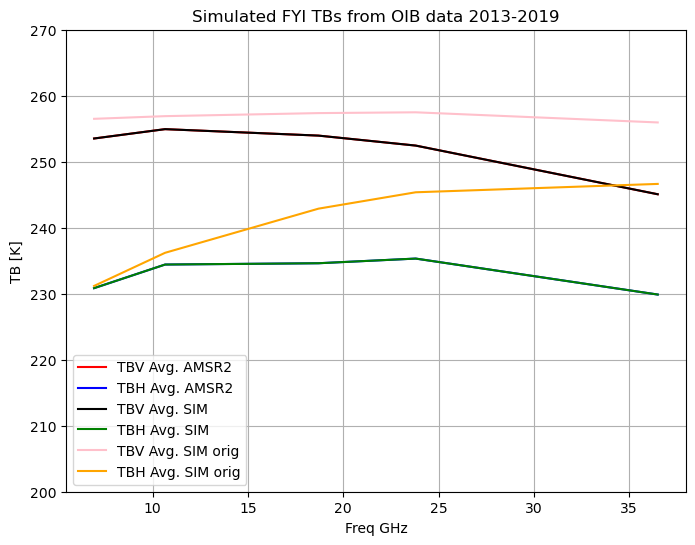

In [7]:
## Plots results
plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]
# x_vars = ["SD", "lex", "rho", "sal",  "SIT", "slope"]
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=3)
print(x_ap)
# x_ap[-1]=0.19
data = forward_OIB_AMSR2(X=x_ap,self=FYI_data,variables=x_vars, nl_snow = nl_snow, n=0, pol='both', logarithmic=True, avg=True, sim=False)

y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
y = data[:5]
plt.plot(freqs, y, c='k', label = 'TBV Avg. SIM')
y = data[5:]
plt.plot(freqs, y, c='green', label = 'TBH Avg. SIM')
y = np.mean(FYI_data.TbV_sim, axis=0)
plt.plot(freqs, y, c='pink', label = 'TBV Avg. SIM orig')
y = np.mean(FYI_data.TbH_sim, axis=0)
plt.plot(freqs, y, c='orange', label = 'TBH Avg. SIM orig')
plt.grid()
plt.ylim([200,270])
plt.legend()
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
plt.show()

[-8.96216557e-01 -3.61978876e+00  2.70000000e+02  1.30000000e-02
  2.53083775e+02  1.43982817e+00  1.90000000e-01]


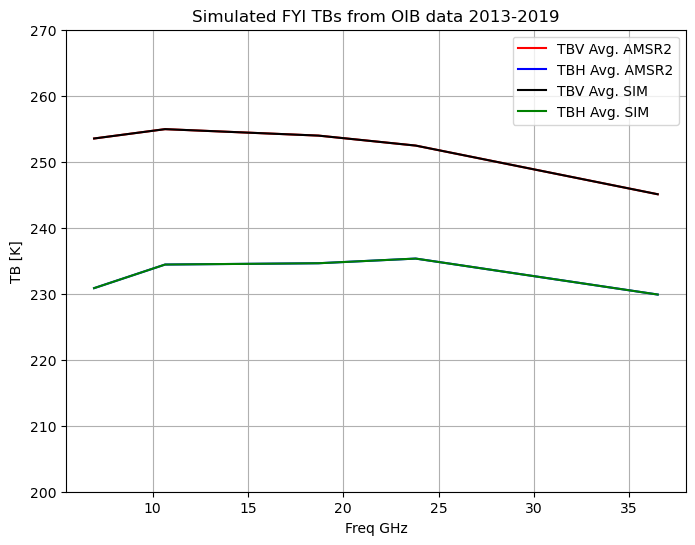

In [8]:
## Plots results
plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]
# x_vars = ["SD", "SIT", "slope"]
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)
print(x_ap)
data = forward_OIB_AMSR2(X=x_ap,self=FYI_data,variables=x_vars, nl_snow = nl_snow, n=0, pol='both', logarithmic=True, avg=True, sim=False)

y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
y = data[:5]
plt.plot(freqs, y, c='k', label = 'TBV Avg. SIM')
y = data[5:]
plt.plot(freqs, y, c='green', label = 'TBH Avg. SIM')
plt.grid()
plt.ylim([200,270])
plt.legend()
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
plt.show()

In [9]:
Bias = FYI_OIB_AMSR - data
print(Bias)

[-1.18447474e-09  2.06972572e-09 -4.88239493e-09 -1.05248432e-09
 -3.45193030e-09 -4.94409846e-09 -3.12468273e-10  4.71965222e-09
  8.91020591e-11  3.05379899e-09]


### Choose looking at only V or at both

### Choose how many input variables 

### choose Sy sensitivity

In [10]:
## Define name of y-variables

if polarization=='both':
    y_vars = ["6V", "10V", "18V", "23V", "36V", "6H", "10H", "18H", "23H", "36H"]
    y_obs  = FYI_OIB_AMSR
    V_sens = np.array([0.3, 0.3, 0.6, 1.1, 1.1])+0.2
    H_sens = np.array([0.3, 0.3, 0.6, 1.1, 1.1])+0.5
    y_cov = np.diag(np.array([0.3, 0.3, 0.6, 1.1, 1.1] + [0.3, 0.3, 0.6, 1.1, 1.1])**2)
    y_cov = np.diag(np.concatenate((V_sens**2, H_sens**2)))
    # y_cov = np.diag(np.array([ 0.79518149 , 1.95518354,  0.78687942, -0.44976116, -1.73411494  ] + [ 2.12858105, 3.72325291,  0.72247579, -0.28446336, -3.19752185])**2)
elif polarization=='V':
    y_vars = ["6V", "10V", "18V", "23V", "36V"]
    # y_obs = np.mean(FYI_data.TbV_sim, axis=0)
    y_obs = np.mean(FYI_data.TbV_AMSR_all, axis=0)
    y_cov = np.diag(np.array([0.3, 0.3, 0.6, 1.1, 1.1])+0.2)**2 # np.diag([V_sens**2]*5)
elif polarization=='VH0':
    y_vars = ["6V", "10V", "18V", "23V", "36V", "H6"]
    # y_obs = np.mean(FYI_data.TbV_sim, axis=0)
    y_obs_p1 = np.mean(FYI_data.TbV_AMSR_all, axis=0)
    y_obs = np.append(y_obs_p1, np.mean(FYI_data.TbH_AMSR_all, axis=0)[0])
    y_cov = np.diag(np.array([0.5, 0.5, 0.5, 1.5, 2.5, 2.5])**2) # np.diag([V_sens**2]*5) 

# Define name of x-variable
# x_vars = input_variables
## prepare first guess, covariance matrix, upper and lower limits
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)

print(x_ap)
#print('Guess in linear units', 10**np.round(x_ap,2)[:3])

[-8.96216557e-01 -3.61978876e+00  2.70000000e+02  1.30000000e-02
  2.53083775e+02  1.43982817e+00  1.90000000e-01]


['SD', 'lex', 'rho', 'sal', 'Tsur', 'SIT', 'slope']
[-8.96216557e-01 -3.61978876e+00  2.70000000e+02  1.30000000e-02
  2.53083775e+02  1.43982817e+00  1.90000000e-01]
[[ 2.62252716e-02  3.02943209e-03 -8.37846232e-01 -2.61002221e-04
   1.00891083e-01  1.98262492e-02  0.00000000e+00]
 [ 3.02943209e-03  5.97907584e-04 -2.45319166e-01 -2.83455316e-05
   2.33642204e-02  2.17433662e-03  0.00000000e+00]
 [-8.37846232e-01 -2.45319166e-01  1.24558788e+02  6.63797401e-03
  -1.06588424e+01 -5.06499223e-01  0.00000000e+00]
 [-2.61002221e-04 -2.83455316e-05  6.63797401e-03  2.91068632e-06
  -1.20795751e-03 -1.95094333e-04  0.00000000e+00]
 [ 1.00891083e-01  2.33642204e-02 -1.06588424e+01 -1.20795751e-03
   1.37229665e+01 -7.31783044e-02  0.00000000e+00]
 [ 1.98262492e-02  2.17433662e-03 -5.06499223e-01 -1.95094333e-04
  -7.31783044e-02  9.24152388e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  4.00000000e-02]]
['6V', '10V',

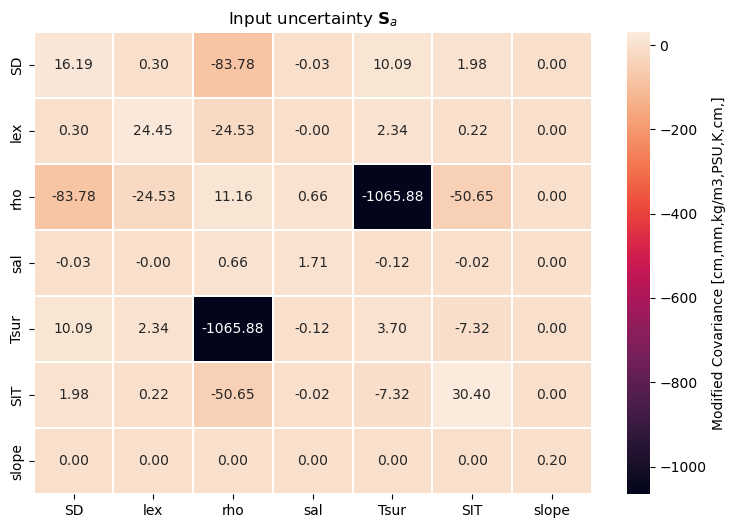

In [11]:
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)

x_cov = XCOV
x_cov[-1,-1] = 0.2**2
print(x_vars)
print(x_ap)
print(x_cov)
print(y_vars)
print(y_obs)
print(y_cov)

# x_cov[2,2]=0.02**2

    

oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2)
title = r'Input uncertainty $\mathbf{S}_{a}$'
covMat(oe_show, oe_show.S_a, title)

Text(0.5, 1.0, 'Measurement uncertainty (STD) $\\mathbf{S}_{y}$')

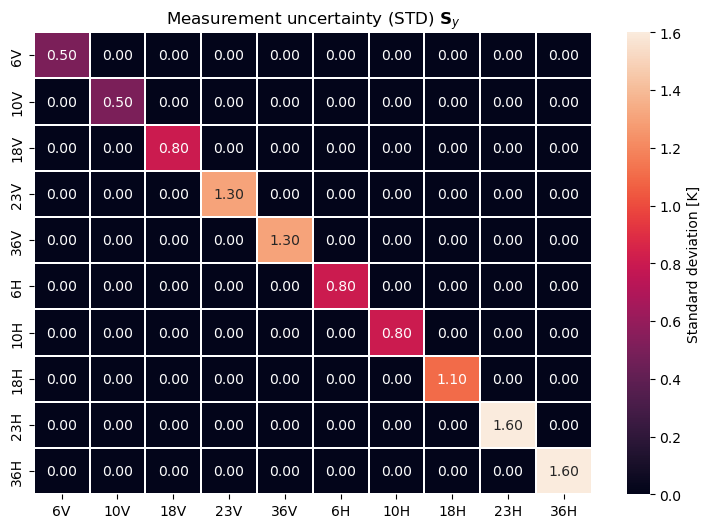

In [12]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    np.sqrt(oe_show.S_y), 
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Standard deviation [K]'}
)
ax.set_title(r'Measurement uncertainty (STD) $\mathbf{S}_{y}$')

[-8.96216557e-01 -3.61978876e+00  2.70000000e+02  1.30000000e-02
  2.53083775e+02  1.43982817e+00  1.90000000e-01]
8.28 s, iteration 1, degrees of freedom: 2.99 of 7, converged (x-space):  0.000
12.20 s, iteration 2, degrees of freedom: 2.99 of 7, done.  0.000
-----------------
TRUE VALUES
-----------------
SD:  0.1269940701468075
lex:  -3818.02271510224
rho:  [348.53339933 337.51818972]
sal:  [0.88802032 8.67319838]
SIT:  1.4398281690140846
-----------------
SD        -0.896217
lex       -3.619789
rho      270.000000
sal        0.013000
Tsur     253.083775
SIT        1.439828
slope      0.190000
dtype: float64
SD     12.699407
lex     0.024000
dtype: float64
-----------------
Jacobian matrix:
      perturbed SD  perturbed lex  perturbed rho  perturbed sal  \
6V       9.117541      -0.069616       0.013164      44.698507   
10V      9.428152      -0.383923       0.014979      66.395431   
18V      9.120144      -3.172431       0.016349     101.685847   
23V      7.562481      -7.276057

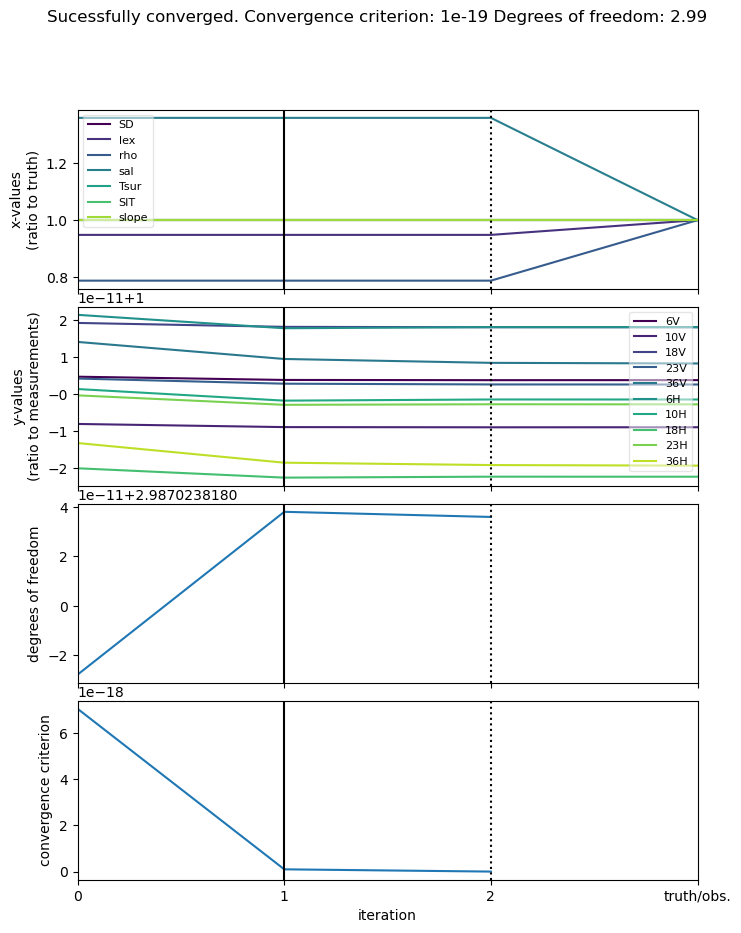

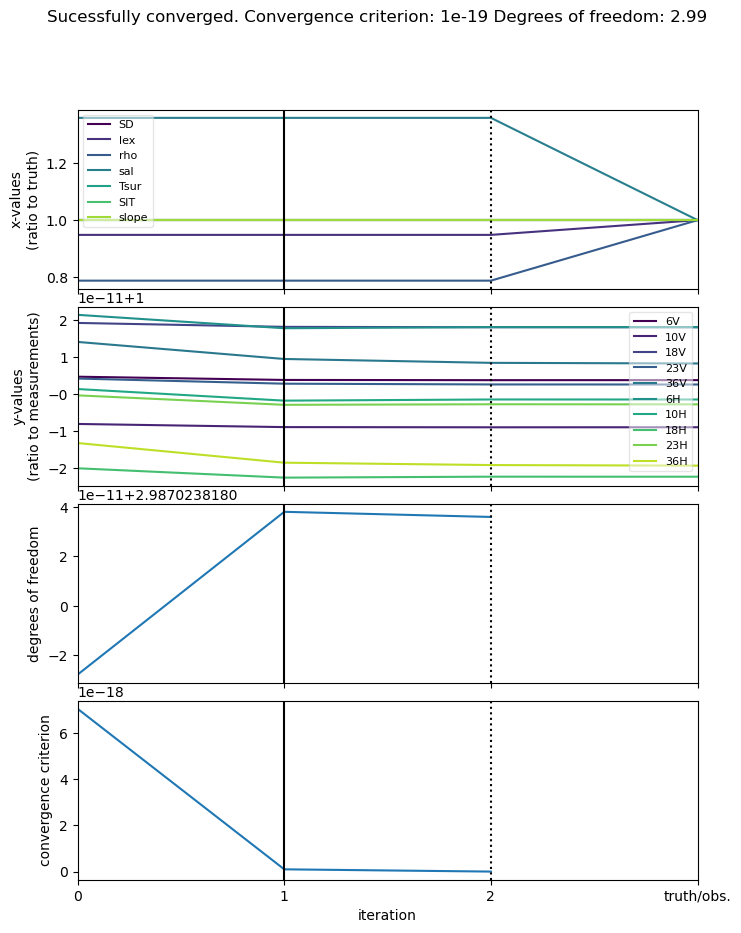

In [13]:
## Iterate over different start guesses
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)
print(x_ap)
x_cov = XCOV
# x_cov[2,2]=0.02**2
forwardKwArgs = {"self": FYI_data, "variables": x_vars, "nl_snow": nl_snow, "n": 0, 
                 "pol":polarization, "logarithmic":True,"avg":True, "sim":False}
# define the optimal estimation
oe = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        ,x_truth=x_truth
        ,convergenceFactor=10
        )
# run the optimization and print outputs
oe.doRetrieval(maxIter=15)
print('-----------------')
print('TRUE VALUES')
print('-----------------')
print('SD: ', 10**np.mean(FYI_data.sd, axis=0))
print('lex: ',np.mean(FYI_data.sd_lex)*1e3)
print('rho: ',np.mean(FYI_data.sd_rho, axis=0))
print('sal: ',np.mean(FYI_data.sd_sal, axis=0)*1e3)
print('SIT: ',np.mean(FYI_data.sit))

print('-----------------')
print(oe.x_op)
print(10**(oe.x_op[:2])*1e2)
#try:
#    print(10**(oe.x_op[1:2])*1e3)
#except:
#    pass
#print((oe.x_op[2]))
print('-----------------')
print('Jacobian matrix:\n', oe.getJacobian(oe.x_op, oe.y_op)[0])
oe.plotIterations()

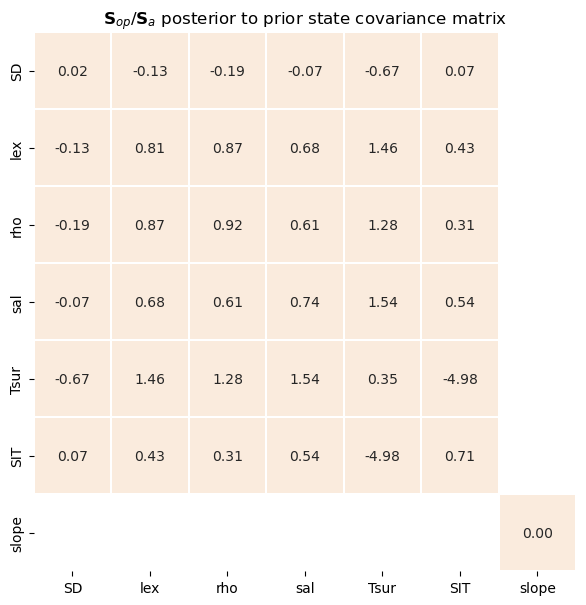

In [14]:
oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2)
covOutMat(oe.S_op, oe_show.S_a, name='Avg_vals')

last iteration not converged


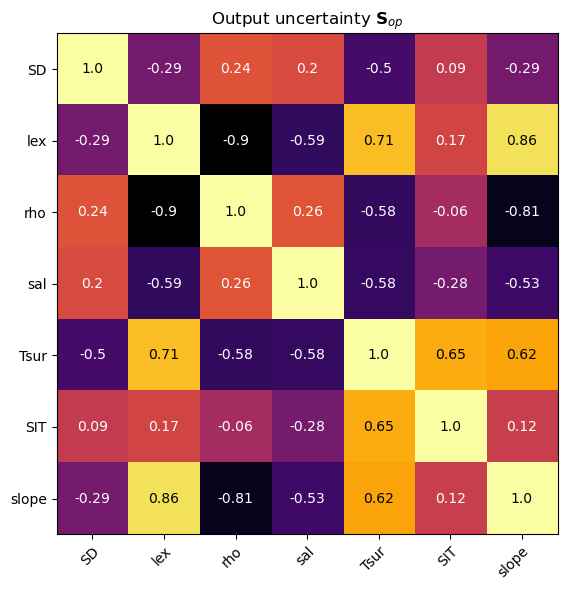

In [15]:
try:
    #def corrMat(data):
    corrMat = np.zeros(oe.S_op.shape)
    sigmas = np.diag(oe.S_op)**(1/2)
    rows = range(oe.S_op.shape[0])
    cols = range(oe.S_op.shape[1])
    for row in rows:
        sigma1 = sigmas[row]
        for col in cols:
            sigma2 = sigmas[col]

            corrMat[row][col] = np.array(oe.S_op)[row][col]/(sigma1*sigma2)




    fig, ax = plt.subplots(figsize=(9, 6))
    im = ax.imshow(corrMat, cmap="inferno")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())
    ax.set_yticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    for i in range(len(oe.S_op.keys())):
        for j in range(len(oe.S_op.keys())):
            if np.round(corrMat[i, j],2) > 0.5:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                       ha="center", va="center", color="k")
            else:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                               ha="center", va="center", color="w")

    ax.set_title(r'Output uncertainty $\mathbf{S}_{op}$')
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


    fig.tight_layout()
    plt.savefig(savepath + str(slope_std) + '_CorrMatrixOut.png' )
    plt.show()
except:
    print('last iteration not converged')

In [ ]:
## calculate angles if we have more than 1 input variable
input_variables=x_vars
text_file = open(savepath + "angles_jacobian.txt", "w")
if len(input_variables)>1:
    for i in range(len(input_variables)):
        for j in range(len(input_variables)):
            if i!=j:
                calc_ang(input_variables[i], input_variables[j])

--------------------------------------------------
Angle between SD and lex vector V: 81.47563642719497
Angle between SD and lex vector H: 106.56437589004048
--------------------------------------------------
Angle between SD and rho vector V: 42.555595681753324
Angle between SD and rho vector H: 17.21134149519771
--------------------------------------------------
Angle between SD and sal vector V: 60.13483877473454
Angle between SD and sal vector H: 24.794628927709606
--------------------------------------------------
Angle between SD and Tsur vector V: 53.39940297991719
Angle between SD and Tsur vector H: 31.306150389981727
--------------------------------------------------
Angle between SD and SIT vector V: 127.68967970114588
Angle between SD and SIT vector H: 149.50740048669925


In [ ]:
## Plots results
plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]

y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
y = oe.y_op[:5]
plt.plot(freqs, y, c='k', label = 'TBV Avg. SIM')
if polarization =='both':
    y = oe.y_op[5:]
    plt.plot(freqs, y, c='green', label = 'TBH Avg. SIM')
plt.grid()
plt.ylim([200,270])
plt.legend()
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
plt.show()

### Test for assumptions

In [ ]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)
chiSquareTest = oe.chiSquareTest(significance=0.05)
print('\nTests passed:\n' ,chiSquareTest[0])

In [ ]:
## Iterate over different start guesses (of SD)
savepath = 'C:/Users/Ida Olsen/Documents/Speciale_2022/Results/Real_data/Report_figures/'
slope_std ='_V_rho'
input_variables = x_vars
for var in input_variables:
    [x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)
    
    print(var)
    print(input_variables)
    #x_cov[0,0] = x_cov[0,0]*2
    # x_cov[-1,-1] = x_cov[-1,-1]*1/2
    cc = []
    x_op = []
    ind = [i==var for i in input_variables]
    if var=='SD':
        if logarithmic==True:
            V0 = np.linspace(np.log10(0.08), np.log10(0.25), 10)
        else:
            V0 = np.linspace(0.08, 0.25, 10)
    elif var=='lex':
        if logarithmic==True:
            V0 =  np.linspace(np.log10(0.2*1e-3), np.log10(0.4*1e-3), 10)
        else:
            V0 =  np.linspace(0.2*1e-3, 0.4*1e-3, 10)
    elif var=='sal':
        V0 =  np.linspace(5*PSU, 20*PSU, 10)
        # V0 =  np.linspace(np.log10(0.1*PSU), np.log10(2*PSU), 10)
    elif var=='rho':
        V0 = np.linspace(200, 400, 10)
    elif var=='Tsur':
        V0 = np.linspace(250, 270, 10)
    elif var=='SIT':
        V0 = np.linspace(0.5, 2.0, 10)
    elif var=='slope':
        V0 = np.linspace(0.05, 0.3, 10)

    for v0 in V0:
        x_ap[ind] =v0
        ## define extra arguments to forward function
        forwardKwArgs = {"self": FYI_data, "variables": x_vars, "nl_snow": nl_snow, "n": 0, 
                         "pol":polarization, "logarithmic":True,"avg":True, "sim":False}
        # define the optimal estimation
        oe = pyOE.optimalEstimation(
                x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2
                ,forwardKwArgs=forwardKwArgs
                ,x_lowerLimit=x_lowerLimit
                ,x_upperLimit=x_upperLimit
                ,x_truth=x_truth
                ,convergenceFactor=10
                )

        try:
            # run the optimization and print outputs
            oe.doRetrieval(maxIter=6)
            oe.plotIterations
            cc.append(oe.S_op)
            x_op.append(oe.x_op)
        except:
            print('NC')
            V0 = np.delete(V0, [np.where(V0==v0)])
        
    ## Plot results
    plt.figure(figsize=(7,7))
    # print(var)
    for i in range(len(input_variables)):
        print(i)
        
        if input_variables[i]!="SIT" and input_variables[i]!="rho" and input_variables[i]!="sal" and input_variables[i]!="slope" and logarithmic==True:
            V = [10**x[input_variables[i]] for x in x_op if ~np.isnan(x).any()]
        else:
            V = [x[input_variables[i]] for x in x_op if ~np.isnan(x).any()]
        if var!="SIT" and var!="rho" and var!="sal" and var!='slope' and logarithmic==True:
            VV0 = [10**v0 for v0,x in zip(V0, x_op) if ~np.isnan(x).any()]
        else:
            VV0 = [v0 for v0,x in zip(V0, x_op) if ~np.isnan(x).any()]
        if input_variables[i]=="lex" or input_variables[i]=="sal":
            V = np.array(V)*1e3
        if var=="lex" or var=="sal":
            VV0 = np.array(VV0)*1e3
        if var=="sal":
            VV0 = VV0/100
        if input_variables[i]=="sal":
            V=V/100
        if var=='rho' or var=='Tsur':
            VV0 = np.array(VV0)/1000
        if input_variables[i]=="rho":
            V = np.array(V)/1000
        if input_variables[i]=="Tsur":
            V = np.array(V)/1000
        if var=="SIT":
            VV0 = np.array(VV0)/10
        if input_variables[i]=="SIT":
            V=np.array(V)/10
        # print(VV0)
        # print(V)
        plt.scatter(VV0, V, label=input_variables[i])
    # print(np.mean(10**FYI_data.sd))
    plt.xlabel(var + ' start guess')
    plt.ylabel(var +' OE')
    if logarithmic==True:
        plt.axhline(10**np.mean(FYI_data.sd, axis=0), color='k', label='mean OIB SD')
    else:
        plt.axhline(np.mean(FYI_data.sd), color='k', label='mean OIB SD')
    plt.axhline(np.mean(FYI_data.sit)/10, color='grey', label='mean OIB SIT/10')
    # plt.axhline(np.mean(FYI_data.sd_lex, axis=0)[0]*1e3, color='b', label='mean OIB lex')
    # plt.axhline(np.mean(FYI_data.sd_sal, axis=0)[0]*1e3/3, color='r', label='mean OIB sal/3')
    plt.xlim([0.04, 0.41])
    plt.ylim([0.04, 0.41])
    #plt.xlim([np.min(VV0)-np.min(VV0)/10,np.max(VV0)+np.max(VV0)/10])
    #plt.ylim([np.min(VV0)-np.min(VV0)/10,np.max(VV0)+np.max(VV0)/10])
    plt.legend()
    plt.grid()
    plt.savefig(savepath + var + '_' + str(slope_std) + '.png' )
    plt.show()

In [13]:
#a = XCOV[1,1]
#XCOV[-1,-1]=0.1**2
def do_OE_sim(ns, slope_cov_frac, slope_std, XCOV, noise=False):
    [x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)
    #x_cov[-1,-1] = x_cov[-1,-1]*slope_cov_frac
    #x_cov[-3,-3] = 1**2 # 1K
    #x_cov[-2,-2] = (0.05)**2 # 5 cm
    if polarization=='both':
        data=zip(FYI_data.TbV_AMSR_all[:ns], FYI_data.TbH_AMSR_all[:ns])
        # data=zip(FYI_data.TbV_sim[:ns], FYI_data.TbH_sim[:ns])
    elif polarization=='V':
        data=FYI_data.TbV_AMSR_all[:ns]
    elif polarization=='VH0':
        data=zip(FYI_data.TbV_AMSR_all[:ns], FYI_data.TbH_AMSR_all[:ns][:,0])
    oe_out = []
    results = []
    x_optimals = []
    nn = [] # [i for i in range(ns)]
    no = []
    for Tb, n in zip(data, range(len(FYI_data.skt[:ns]))):
        [x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, n=n, logarithmic=True, nl_snow=nl_snow)
        # if len(XCOV)>0:
        x_cov = XCOV
        # x_cov[-1,-1]=0.2**2
        # x_cov[1,1]=a*1.1
        print('Point number: ', n)
        # y_obs = np.append(Tb[0],Tb[1])
        if polarization=='both':
            #print(y_obs)
            y_obs = np.concatenate(Tb)
        else:
            y_obs = Tb
        ## define extra arguments to forward function
        forwardKwArgs = {"self": FYI_data, "variables": x_vars, "nl_snow": nl_snow, "n": n, 
                         "pol":polarization, "logarithmic":True,"avg":False, "sim":False}
        # define the optimal estimation
        oe = pyOE.optimalEstimation(
                x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2
                ,forwardKwArgs=forwardKwArgs
                ,x_lowerLimit=x_lowerLimit
                ,x_upperLimit=x_upperLimit
                ,x_truth=x_truth
                ,convergenceFactor=10
                )
        try:
            oe.doRetrieval(maxIter=4)
            # print(oe.S_ai)
            # linearity, trueLinearityChi2, trueLinearityChi2Crit = oe.linearityTest(significance=0.05)
            #if trueLinearityChi2 < trueLinearityChi2Crit:
            #    T_percentage
            # print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)
            # chiSquareTest = oe.chiSquareTest(significance=0.05)
            #print('\nTests passed:\n' ,chiSquareTest[0])
            #print(len(np.where(chiSquareTest[0]==True)[0]))
            #if all(chiSquareTest[0]):
            print(len(oe.x_op))
            if len(oe.x_op)>1:
                print('convergence reached')
                nn.append(n)
                x_optimals.append(oe.x_op)
                results.append(oe.y_op)
                oe_out.append(oe)

        except:
            print('Convergence not reached')
            # nn.remove(n)
            no.append(n)
    return [nn, no, oe_out, x_optimals, results]

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import math

def RMSE(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
    
    print("Root Mean Square Error:")
    print(RMSE)
    return RMSE

In [15]:
def plot_idv(variables, OIB_data, nn, slope_std):
    no = []
    input_variables=x_vars

   
    for var, data in zip(variables, OIB_data): 
        OE = []
        OE_err = []
        OIB = []
        #set limits
        for oe, n in zip(oe_out, nn):
            x_optim = oe.x_op
            try:
                if (var=='SD' or var=='lex') and logarithmic==True:
                    # convert from log to linear units
                    OE.append(10**x_optim[var])
                    #OE.append(x_optim[var])
                    # OE_err.append(oe.S_op[var][var]/oe.S_a[var][var]*np.array(OE)[n])
                    # print(OE_err[n])
                else:
                    OE.append(x_optim[var.replace('1', '')])
                OIB.append(data[n])
                # print(OIB)
            except:
                # print('convergence was not reached at: ', n)
                no.append(n)
        
        if var=='SD' or var=='sal' or var=='lex':
            OIB = np.array(OIB)
            
        
        #print(np.shape(OIB))
        #print(np.shape(OE))
        if var=='SD':
            xlim = [0.03, 0.35]
            x = 0.05
            y = 0.33
            y1 = 0.30
            unit = ' [m]'
        elif var=='sal':
            xlim = [10, 25.0]
            unit = ' [PSU]'
            OIB = np.array(OE)*1e3
            # OIB = OIB*1e3
            x = 10.8
            y = 12.9
            OE = np.array(OE)*1e3
        elif var=='Tsur':
            xlim = [240.0, 260.0]
            unit = ' [K]'
            x = 245.0
            y = 257.0
            y1 = 255.0
        elif var=='lex':
            OIB = np.array(OE)*1e3
            OE = np.array(OE)*1e3
            xlim = [0.15, 0.35]
            unit = ' [mm]'
            x = 0.18
            y = 0.28
            #OIB = OIB*1e3
            #OE = np.array(OE)*1e3
        elif var=='SIT':
            xlim = [0.5, 3.0]
            x = 0.75
            y = 2.9
            y1 = 2.6
            unit = ' [m]'
        elif var=='slope':
            # print(OIB)
            # print('OE value')
            # print(OE)
            OIB = OE
            xlim = [0.05, 0.4]
            x = 0.1
            y = 0.3
            unit = ' '
        elif 'rho' in var:
            #print(var)
            #print(OIB)
            #OIB = np.array(OIB)[:,1]
            OIB = OE
            xlim = [100, 400]


        ## make predictions and fit
        #print(np.array(OIB))
        #print(np.array(OE).shape)
        model = np.polyfit(OIB, OE, 1)
        model2 = np.polyfit(OIB, OIB, 1)
        
        predict = np.poly1d(model)
        predict2 = np.poly1d(model2)

        
        rr2=r2_score(OE, predict2(OIB))
        
        x_lin_reg = range(-1, 500)
        y_lin_reg = predict(x_lin_reg)

        x_one2one = range(-1, 500)
        y_one2one = predict2(x_lin_reg)
        
        rmse = RMSE(OIB, OE)
        
        
        if var=='SD' or var=='SIT' or var=='Tsur':
            rr=r2_score(OIB, OE)
            plt.figure(figsize=(6,6))
            BD = np.where(abs(np.array(OIB)-np.array(OE))>rmse)[0]
            print(BD)
            plt.scatter(OIB, OE)
            # plt.errorbar(OIB, OE, yerr=None, xerr=None)
            # plt.scatter(np.array(OIB)[BD.astype(int)], np.array(OE)[BD.astype(int)])
            #plt.plot(x_lin_reg, y_lin_reg, c = 'gray')
            plt.plot(x_one2one, y_one2one, c = 'black')
            plt.grid()
            plt.title(var + '_comparison OE/OIB')
            plt.xlabel(var + '_OIB' + unit)
            plt.ylabel(var + '_OE' + unit)
            plt.xlim(xlim)
            # square plot
            plt.ylim(xlim)
            #if var=='SD':
            plt.text(x, y, 'RMSE: ' + str(np.round(RMSE(OIB, OE),3)) + ' , STD:' + str(np.round(np.std(OIB),3)))
            plt.text(x, y1, 'R2: ' + str(np.round(rr,3)))
        

        
        # print('R2-score: ',r2_score(OIB,OE))
        #
            # plt.text(x, y-0.06, 'R2: ' + str(np.round(rr2,3)))
            plt.savefig(savepath + var + slope_std +'_idv.png' )
            plt.show()
    return BD

In [16]:
def hist_idv(variables, OIB_data, nn, slope_std):

   
    for var, data in zip(variables, OIB_data): 
        OE = []
        OIB = []
        #set limits
        try:
            for x_optim, n in zip(x_optimals, nn):
                    OE.append(x_optim[var])
                    OIB.append(data[n])
        except:
            pass
            # print('convergence was not reached at: ', x_optim)
        
        if var=='SD':
            OE = 10**np.array(OE)
            bins = np.linspace(0, 0.35, 50)
            unit = ' [m]'
        elif var=='sal':
            OE = np.array(OE)*1e3
            OIB = np.array(OIB)*1e3
            bins = np.linspace(10, 20, 50)
            unit = ' [PSU]'
        elif var=='rho':
            bins = np.linspace(250, 320, 50)
            unit = ' [kg/m3]'
        elif var=='lex':
            OE = 10**np.array(OE)*1e3
            OIB = np.array(OIB)*1e3
            bins = np.linspace(0.15, 0.35, 50)
            unit = ' [mm]'
        elif var=='Tsur':
            unit = ' [K]'
            bins = np.linspace(230, 260, 100)
        elif var=='SIT':
            bins = np.linspace(0, 3, 50)
            unit = ' [m]'
        elif var=='slope':
            bins = np.linspace(0.15, 0.25, 50)
            unit = ' '
        plt.figure(figsize=(8,6))
        if var!='sal' and var!='rho' and var!='lex' and var!='slope':
            plt.hist(OIB, bins=bins,alpha=0.5,rwidth=0.85, color='red', label = var + ' True')
        plt.hist(OE, bins=bins, alpha=0.5,rwidth=0.85, label = var + ' OE')
        plt.legend(loc='upper right', fontsize=12)
        plt.xlabel(var + unit, fontsize=12)
        # plt.grid()
        plt.ylabel('Count', fontsize=12)
        plt.savefig(savepath + var + slope_std + '_hist.png',bbox_inches='tight')
        plt.show()

In [17]:
# nn = [i for i in range(ns)]
def conv_not_conv(input_variables, OIB_data_plot, nn, no, slope_std):
    nn  = np.array(nn, dtype=int)
    no  = np.array(np.unique(no), dtype=int)

    fig, ax = plt.subplots(3, figsize=(7,10), sharex=False)

    vars = ['SD', 'SIT', 'Tsur']
    xlabel = ['m', 'm','K']
    xlim = [[0,0.4], [0,3], [240, 270]]
    binss = [np.linspace(0, 1, 50), np.linspace(0, 5, 100), np.linspace(230, 270, 50)]
    # bins = 
    for var, i in zip([10**FYI_data.sd, FYI_data.sit, FYI_data.skt], range(3)):
        bins = binss[i]
        ax[i].hist(var[nn], bins=bins, rwidth=0.85, alpha=0.5, label = 'converged, ' + str(len(nn)))
        ax[i].hist(var[no], bins=bins, rwidth=0.85, alpha=0.5, label='not converged, ' + str(len(no)))
        ax[i].set_yticks([])
        ax[i].set_ylabel(str(vars[i]))
        ax[i].set_xlabel(xlabel[i])
        ax[i].set_xlim(xlim[i])

    plt.legend(bbox_to_anchor=(1.35, 3.3))
    plt.savefig(savepath + str(slope_std) +'_hist.png', bbox_inches='tight')

In [18]:
## degrees of freedom
def dgf(oe_out, nn, slope_std):
    df = [r.dgf for r in oe_out]
    plt.figure(figsize=(6,6))
    plt.scatter(nn, df)
    plt.grid()
    plt.title('Degrees of freedom')
    plt.xlabel('point')
    plt.ylabel('dgf')
    plt.ylim(0,6)
    plt.savefig(savepath + slope_std + '_degrees of freedom.png' )
    plt.show()

In [19]:
def corr_avg_cov_avg(oe_out, specifier):
    oe_comb = np.mean([r.S_op for r in oe_out], axis=0)
    x_cov = XCOV
    oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2)
    corrMat(oe_out[0], oe_comb, specifier=specifier)
    covOutMat(oe_comb,oe_show.S_a, name=specifier)

['SD', 'lex', 'rho', 'sal', 'Tsur', 'SIT', 'slope']
Root Mean Square Error:
0.03325831487098616
[ 14  50  62  70  72  80  86  87  89  90  92  98  99 103 104 105 108 109
 111 114 115 116 117 118 119 120 121 122 132 134 135 140 141 145 150 151
 170 182 186 199 205 207 209 212 219 220 221 222 226 227 228 229 230 231
 234 237 243 248 249 250 251 252 254 255 257 258 259 260 261 262 263 264
 266 272 273 276 277 278 280 282 287 288 289 290 291 292 293]
Root Mean Square Error:
0.03325831487098616


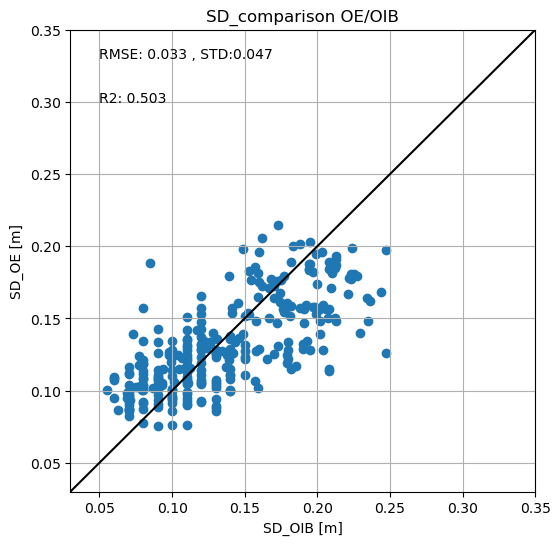

Root Mean Square Error:
0.0
Root Mean Square Error:
0.0
Root Mean Square Error:
0.0
Root Mean Square Error:
2.594015003817387
[  1   3   4   5  13  16  17  20  21  25  26  27  28  29  30  31  44  45
  46  47  51  52  53  54  58  59  60  61  62  67  69  71  82  83  95  96
 103 104 105 106 107 108 109 111 112 113 115 116 117 118 121 127 128 130
 149 150 151 153 154 155 156 157 158 159 160 161 163 167 207 210 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 256
 257 258 260 261 262 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 287]
Root Mean Square Error:
2.594015003817387


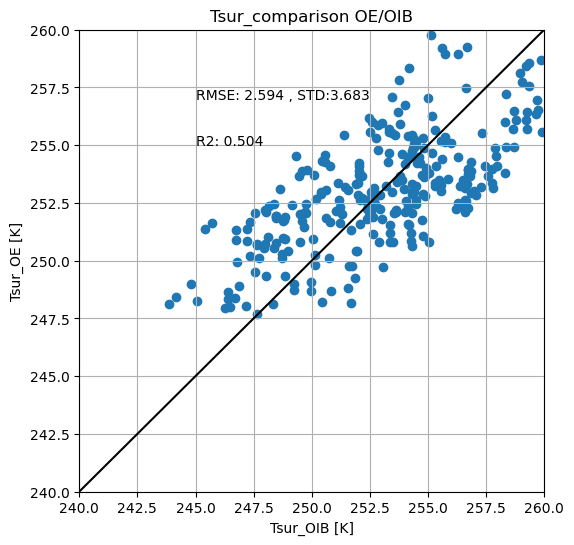

Root Mean Square Error:
0.3117039779739934
[  1   2   3   7   9  10  13  14  15  16  17  18  19  21  22  23  24  36
  51  56  57  64  77  81  85  88  89  91  94  97 101 103 104 105 110 111
 112 113 114 115 116 117 118 119 120 129 130 134 136 137 138 139 144 147
 153 154 155 157 158 159 160 161 162 169 170 177 178 186 189 192 193 194
 195 201 204 207 210 211 214 215 216 219 220 221 222 224 225 226 232 248
 257 266 267 269 270 292]
Root Mean Square Error:
0.3117039779739934


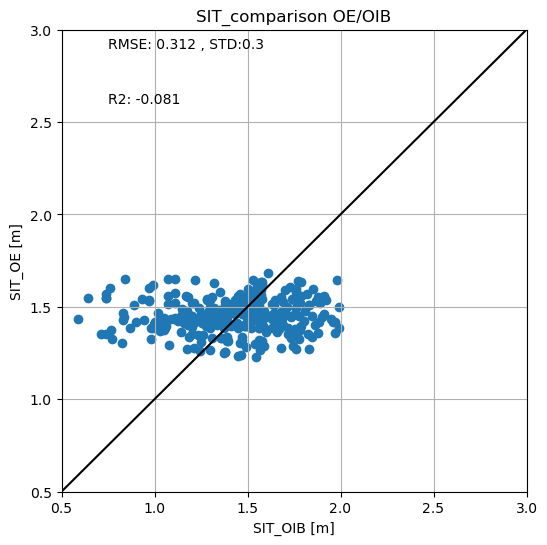

Root Mean Square Error:
0.0


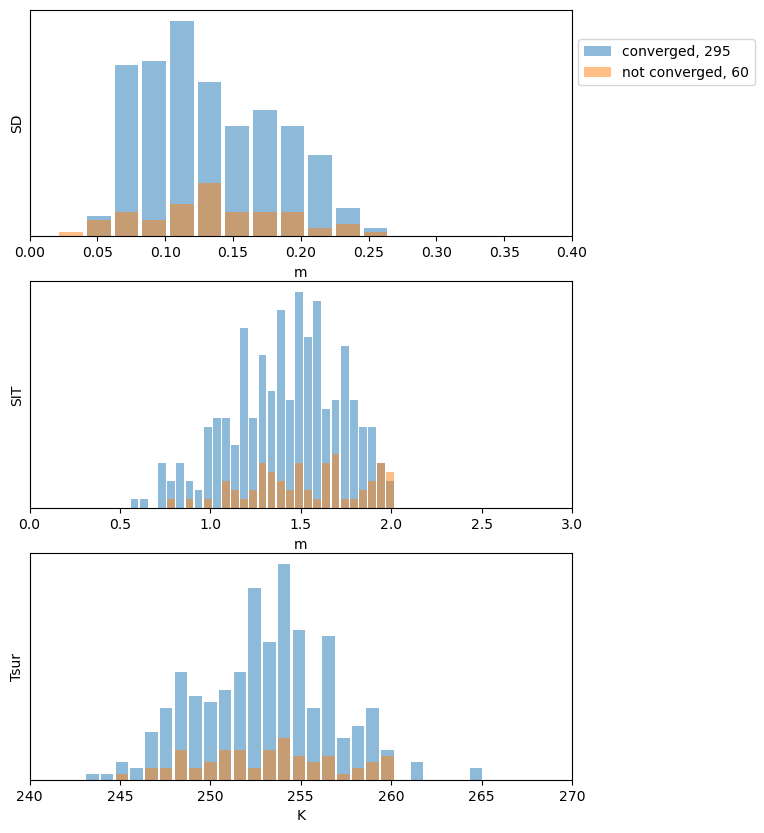

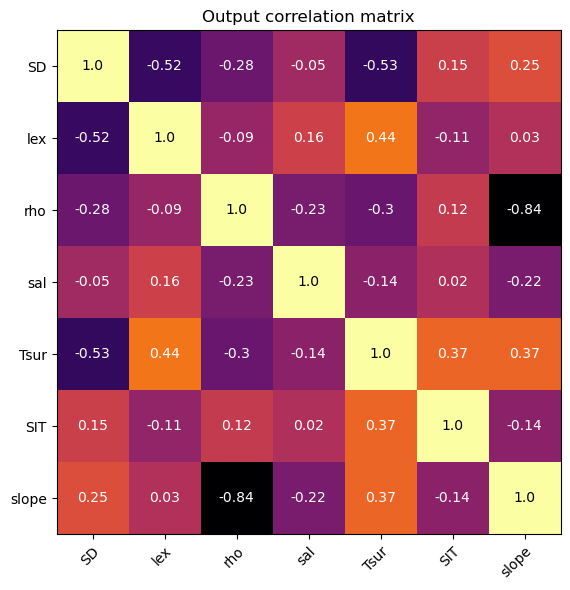

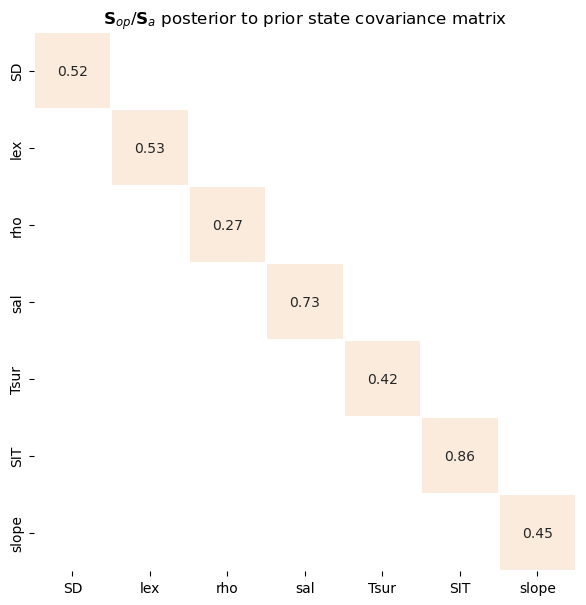

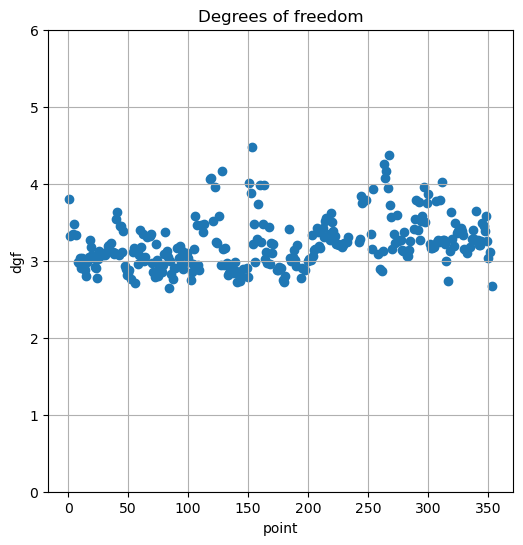

Root Mean Square Error:
0.03325831487098616
RMSE:  0.03325831487098616
STD:  0.04716442234191264
MAE:  0.02630604609269912
R:  (0.7175239669923648, 6.208534425239409e-48)
R-sqaured:  0.5027538354285848
Bias:  0.004657262414335942
#points conv.:  295


"\n#slope_cov_array = [0.01, 0.03, 0.08, 0.14]\n#for slope in slope_cov_array:\n    x_covv = [[] for var in x_vars]\n    x_covv[0] = [sd for sd in FYI_data.sd]\n    x_covv[1] = [sd_lex for sd_lex in FYI_data.sd_lex]\n    x_covv[2] = [rho[-1] for rho in FYI_data.sd_rho]\n    x_covv[3] = [sal[-1] for sal in FYI_data.sd_sal]\n    x_covv[4] = [Tsur for Tsur in FYI_data.skt]\n    x_covv[5] = [sit for sit in FYI_data.sit]\n    x_covv[6] = [0 for r in FYI_data.OIB_surf_rough[~np.isnan(FYI_data.OIB_surf_rough)]]\n    XCOV = np.cov(x_covv)\n    #[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)\n    #XCOV = x_cov\n    XCOV[-1,-1]=slope**2\n    # XCOV[4,4]=1.5**2 # 1.5 K std \n    print(XCOV)\n    f='both_with_cov' + str(slope)\n    [nn, no, oe_out, x_optimals, results] = do_OE_sim(ns, 1, str(f),XCOV)\n    BD = plot_idv(input_variables, OIB_data_plot, nn, str(f))\n    BD = hist_idv(input_variables, OIB_data_plot, nn, str(f))\n    conv_no

In [31]:
# take nn of each
OIB_data_plot = []
input_variables = x_vars
print(input_variables)

if 'SD' in input_variables:
    if logarithmic==True:
        OIB_data_plot.append(10**FYI_data.sd)
        # OIB_data_plot.append(FYI_data.sd)
    else:
        OIB_data_plot.append(FYI_data.sd)
if 'lex' in input_variables:
    if logarithmic==True:
        OIB_data_plot.append(10**FYI_data.sd_lex)
    else:
        OIB_data_plot.append(FYI_data.sd_lex)
if 'rho' in input_variables:
    OIB_data_plot.append(FYI_data.sd_rho)
    
if 'sal' in input_variables:
    OIB_data_plot.append(FYI_data.sd_sal)
if 'Tsur' in input_variables:
    OIB_data_plot.append(FYI_data.skt)
if 'SIT' in input_variables:
    OIB_data_plot.append(FYI_data.sit)
if 'slope' in input_variables:
    OIB_data_plot.append(FYI_data.OIB_surf_rough)
    
savepath = 'C:/Users/Ida Olsen/Documents/Speciale_2022/Results/Real_data/Report_figures/Tests/'
# frac = [0.2, 0.5, 0.75, 1, 1.25, 1.5, 2.0, 3.0]
ns=len(FYI_data.skt)
ofile =savepath + 'Statistics.txt'

lex_frac_array = [0.5] # , 0.3]
for lex in lex_frac_array:
    x_covv = [[] for var in x_vars]
    x_covv[0] = [sd for sd in FYI_data.sd]
    x_covv[1] = [sd_lex for sd_lex in FYI_data.sd_lex]
    x_covv[2] = [rho[-1] for rho in FYI_data.sd_rho]
    x_covv[3] = [sal[-1] for sal in FYI_data.sd_sal]
    x_covv[4] = [Tsur for Tsur in FYI_data.skt]
    x_covv[5] = [sit for sit in FYI_data.sit]
    x_covv[6] = [0 for r in FYI_data.OIB_surf_rough[~np.isnan(FYI_data.OIB_surf_rough)]]

    XCOV = np.cov(x_covv)
    XCOV[-1,-1]=0.1**2
    [x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)
    XCOV = x_cov
    #print(x_cov)
    XCOV[1,1]=XCOV[1,1]*lex
    # XCOV[4,4]=1.5**2 # 1.5 K std 
    #print(XCOV)
    f='both_without_cov' + str(lex)
    #[nn, no, oe_out, x_optimals, results] = do_OE_sim(ns, 1, str(f),XCOV)
    BD = plot_idv(input_variables, OIB_data_plot, nn, str(f))
    #BD = hist_idv(input_variables, OIB_data_plot, nn, str(f))
    conv_not_conv(input_variables, OIB_data_plot, nn, no, str(f))
    corr_avg_cov_avg(oe_out, str(f))
    dgf(oe_out, nn, str(f))


    sd_OE = [r.x_op[0] for r in oe_out]
    r=pearsonr(10**np.array(FYI_data.sd[nn]), 10**np.array(sd_OE))
    mae=mean_absolute_error(10**np.array(FYI_data.sd[nn]), 10**np.array(sd_OE))
    b = np.sum(10**np.array(FYI_data.sd[nn])-10**np.array(sd_OE))/len(nn)
    r2 = r2_score(10**np.array(FYI_data.sd[nn]),10**np.array(sd_OE))
    rmse = RMSE(10**np.array(FYI_data.sd[nn]),10**np.array(sd_OE))
    std = np.std(10**np.array(FYI_data.sd[nn]))

    output=open(ofile,'a')
    print('RMSE: ',rmse)
    print('STD: ',std)
    print('MAE: ',mae)
    print('R: ',r)
    print('R-sqaured: ',r2)
    print('Bias: ',b)
    print('#points conv.: ',len(nn))
    print('%5s & %5.2f &  %5.2f & %5.2f & %5.2f & %5.2f & %5.2f & %5i & %5i' % ('lex test' + polarization +' ' + f,rmse,std,mae,r[0],r2,b,len(nn),len(no)),file=output)
    output.close()
"""
#slope_cov_array = [0.01, 0.03, 0.08, 0.14]
#for slope in slope_cov_array:
    x_covv = [[] for var in x_vars]
    x_covv[0] = [sd for sd in FYI_data.sd]
    x_covv[1] = [sd_lex for sd_lex in FYI_data.sd_lex]
    x_covv[2] = [rho[-1] for rho in FYI_data.sd_rho]
    x_covv[3] = [sal[-1] for sal in FYI_data.sd_sal]
    x_covv[4] = [Tsur for Tsur in FYI_data.skt]
    x_covv[5] = [sit for sit in FYI_data.sit]
    x_covv[6] = [0 for r in FYI_data.OIB_surf_rough[~np.isnan(FYI_data.OIB_surf_rough)]]
    XCOV = np.cov(x_covv)
    #[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)
    #XCOV = x_cov
    XCOV[-1,-1]=slope**2
    # XCOV[4,4]=1.5**2 # 1.5 K std 
    print(XCOV)
    f='both_with_cov' + str(slope)
    [nn, no, oe_out, x_optimals, results] = do_OE_sim(ns, 1, str(f),XCOV)
    BD = plot_idv(input_variables, OIB_data_plot, nn, str(f))
    BD = hist_idv(input_variables, OIB_data_plot, nn, str(f))
    conv_not_conv(input_variables, OIB_data_plot, nn, no, str(f))
    corr_avg_cov_avg(oe_out, str(f))
    dgf(oe_out, nn, str(f))


    sd_OE = [r.x_op[0] for r in oe_out]
    r=pearsonr(10**np.array(FYI_data.sd[nn]), 10**np.array(sd_OE))
    mae=mean_absolute_error(10**np.array(FYI_data.sd[nn]), 10**np.array(sd_OE))
    b = np.sum(10**np.array(FYI_data.sd[nn])-10**np.array(sd_OE))/len(nn)
    r2 = r2_score(10**np.array(FYI_data.sd[nn]),10**np.array(sd_OE))
    rmse = RMSE(10**np.array(FYI_data.sd[nn]),10**np.array(sd_OE))
    std = np.std(10**np.array(FYI_data.sd[nn]))

    output=open(ofile,'a')
    print('RMSE: ',rmse)
    print('STD: ',std)
    print('MAE: ',mae)
    print('R: ',r)
    print('R-sqaured: ',r2)
    print('Bias: ',b)
    print('#points conv.: ',len(nn))
    print('%5s & %5.3f &  %5.3f & %5.3f & %5.3f & %5.3f & %5.3f & %5i & %5i' % ('slope test' + polarization +' ' + f,rmse,std,mae,r[0],r2,b,len(nn),len(no)),file=output)
    output.close()
"""

In [ ]:
output=open(ofile,'a')
print('RMSE: ',rmse)
print('STD: ',std)
print('MAE: ',mae)
print('R: ',r)
print('R-sqaured: ',r2)
print('Bias: ',b)
print('#points conv.: ',len(nn))
print('%5s & %5.2f &  %5.2f & %5.2f & %5.2f & %5.2f & %5.2f & %5i & %5i' % ('Slope test' + polarization +' ' + f,rmse,std,mae,r[0],r2,b,len(nn),len(no)),file=output)
output.close()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr


In [ ]:
import math
# nn = [i for i in range(ns)]
nn  = np.array(nn, dtype=int)
nnn = nn # np.delete(nn, no)
# no  = np.array(np.unique(no), dtype=int)

SD_OE = [10**oe.x_op[0] for oe in np.array(oe_out)]
rho_OE = [oe.x_op[1] for oe in np.array(oe_out)]
sal_OE = [oe.x_op[2] for oe in np.array(oe_out)]
slope_OE = [oe.x_op[3] for oe in np.array(oe_out)]
# tsk_OE = [oe.x_op[4] for oe in np.array(oe_out)[nnn]]


vars = ['SD', 'rho', 'sal', ' slope']
xlabel = ['m', 'kg/m3', '', '']
xlim = [[0,0.4], [150, 450], [5/1000,20/1000],[0.05, 0.5]]
binss = [np.linspace(0, 1, 100), np.linspace(200, 400, 100),
         np.linspace(0, 20/1000, 100),
         np.linspace(0.1, 0.4, 100)]

std_diag = np.sqrt(np.diag(x_cov))
std_diag[0] = 10**std_diag[0]
#std_array = np.sqrt(np.diag(x_cov))
#oe_out
fig, ax = plt.subplots(4, figsize=(7,10), sharex=False)
for var, i in zip([SD_OE, rho_OE, sal_OE, slope_OE], range(4)):
    bins = binss[i]
    ax[i].hist(np.array(var), bins=bins, rwidth=0.85, alpha=0.5)
    # ax[i].hist(var[no], bins=bins, rwidth=0.85, alpha=0.5, label='not converged, ' + str(len(no)))
    ax[i].axvline(np.array(var).mean(), color='r', linestyle='dashed', linewidth=1)
    ## the "input cov std"
    ax[i].axvline(np.array(var).mean()-std_diag[i], color='k', linestyle='dashed', linewidth=1)
    ax[i].axvline(np.array(var).mean()+std_diag[i], color='k', linestyle='dashed', linewidth=1)
    ## the real std
    ax[i].axvline(np.array(var).mean()-np.array(var).std(), color='r', linestyle='dashed', linewidth=1)
    ax[i].axvline(np.array(var).mean()+np.array(var).std(), color='r', linestyle='dashed', linewidth=1)
    ax[i].set_yticks([])
    ax[i].set_ylabel(str(vars[i]))
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_xlim(xlim[i])
    
#plt.legend(bbox_to_anchor=(1.35, 3.3))
#plt.savefig(savepath + str(slope_std) +'_variables_distribution_hist_p2.png', bbox_inches='tight')

[  1   2   3   7   9  10  13  14  15  16  17  18  19  21  22  23  24  36
  51  56  57  64  77  81  85  88  89  91  94  97 101 103 104 105 110 111
 112 113 114 115 116 117 118 119 120 129 130 134 136 137 138 139 144 147
 153 154 155 157 158 159 160 161 162 169 170 177 178 186 189 192 193 194
 195 201 204 207 210 211 214 215 216 219 220 221 222 224 225 226 232 248
 257 266 267 269 270 292]


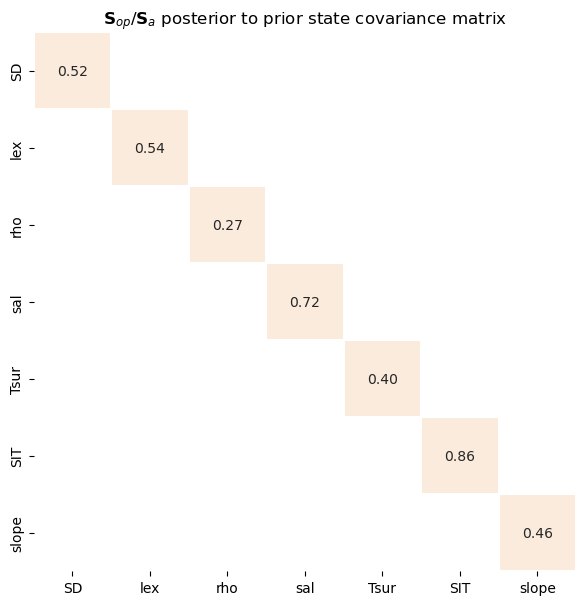

In [35]:
#rel = np.array(oe_out)[BD.astype(int)]
rel = np.array(oe_out)[BD.astype(int)]
print(BD)

oe_comb = np.mean([r.S_op for r in rel], axis=0)
oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2)
covOutMat(oe_comb, oe_show.S_a, name='bad_out')



[  0   4   5   6   8  11  12  20  25  26  27  28  29  30  31  32  33  34
  35  37  38  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54
  55  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75
  76  78  79  80  82  83  84  86  87  90  92  93  95  96  98  99 100 102
 106 107 108 109 121 122 123 124 125 126 127 128 131 132 133 135 140 141
 142 143 145 146 148 149 150 151 152 156 163 164 165 166 167 168 171 172
 173 174 175 176 179 180 181 182 183 184 185 187 188 190 191 196 197 198
 199 200 202 203 205 206 208 209 212 213 217 218 223 227 228 229 230 231
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 249 250 251
 252 253 254 255 256 258 259 260 261 262 263 264 265 268 271 272 273 274
 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 293
 294]


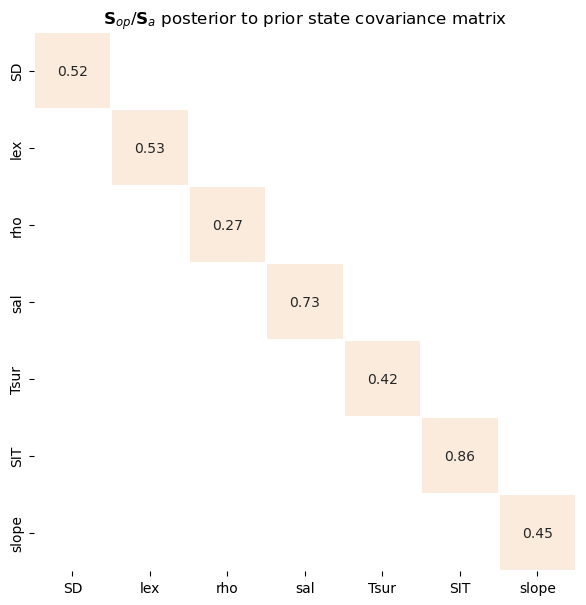

In [42]:
#rel = np.array(oe_out)[BD.astype(int)]
nnn = [i for i in range(len(oe_out))]
good = np.delete(nnn, BD.astype(int))
print(good)
rel = np.array(oe_out)[good]


oe_comb = np.mean([r.S_op for r in rel], axis=0)
oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2)
covOutMat(oe_comb, oe_show.S_a, name='good_out')



In [ ]:
FYI_data.lat[BD]
FYI_data.lon[BD]
FYI_data.date[BD]

In [ ]:
from polar_plots_pred import polar_plot as pp

In [ ]:
FYI_data_plot = OIB_data('FYI', new=True)

FYI_data_plot.lat = FYI_data.lat[no] 
FYI_data_plot.lon = FYI_data.lon[no]
FYI_data_plot.sit = FYI_data.sit[no]
title= 'not converged'

pp(FYI_data_plot, FYI_data_plot.sit, title, ylabel='SIT [m]', clim=False, savename=False, saveloc=False, s=20)

In [ ]:
FYI_data_plot = OIB_data('FYI', new=True)

FYI_data_plot.lat = FYI_data.lat[nn[:-1]] 
FYI_data_plot.lon = FYI_data.lon[nn[:-1]]
FYI_data_plot.sit = FYI_data.sit[nn[:-1]]
title= 'Converged'

pp(FYI_data_plot, FYI_data_plot.sit, title, ylabel='SIT [m]', clim=False, savename=False, saveloc=False, s=7)

In [ ]:
FYI_data_plot = OIB_data('FYI', new=True)
FYI_data_plot.lat = FYI_data.lat[BD] 
FYI_data_plot.lon = FYI_data.lon[BD]
FYI_data_plot.sit = FYI_data.sit[BD]
title= 'RMSE Large'

pp(FYI_data_plot, FYI_data_plot.sit, title, ylabel='SIT [m]', clim=False, savename=False, saveloc=False, s=8)